In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Preprocessing**



In [3]:
# Load the content into a pandas DataFrame
data = pd.read_csv('/content/drive/My Drive/SpamVsHam.tsv',sep='\t', header=None, names=['label', 'message'])
# Display the first few rows of the dataframe
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# Initialize an empty list to store the processed data
processed_data = []

# Initialize variables to store the current message and label
current_message = []
current_label = ''

with open('/content/drive/My Drive/SpamVsHam.tsv', 'r', encoding='utf-8') as file:
    for line in file:
        # Check if the line starts with "ham\t" or "spam\t"
        if line.startswith('ham\t') or line.startswith('spam\t'):
            # If the current message is not empty, add it to the processed data
            if current_message:
                processed_data.append([current_label, ' '.join(current_message)])
            # Reset the current message
            parts = line.strip().split('\t', 1)  # Split the label and message
            if len(parts) == 2:  # Ensure correct splitting
                current_label, message = parts
                current_message = [message]  # Start new message
        else:
            # If the line is not the start of a new message, add it to the current message
            current_message.append(line.strip())

# Make sure the last message is added
if current_message:
    processed_data.append([current_label, ' '.join(current_message)])

# Convert the processed data into a pandas DataFrame
data = pd.DataFrame(processed_data, columns=['label', 'message'])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5574 non-null   object
 1   message  5574 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


**Data Cleansing** : Tokenization、Stop Words Removal、Lemmatization

In [5]:
import spacy
import re

# Load the English language model once
nlp = spacy.load('en_core_web_sm')

# Function to clean and preprocess text
def preprocess_text(text, nlp_model):
    # Convert text to lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special symbols and punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Replace newline characters and extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenization, remove stopwords, and perform lemmatization
    doc = nlp_model(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]

    return tokens

# Apply the preprocessing function to each message
data['processed'] = data['message'].apply(lambda x: preprocess_text(x, nlp))


**Splitting Data**

In [6]:
X = data['processed'] #features
y = data['label']   #labels

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

### **Vectorization**

1. TF-IDF



In [8]:
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer='word', token_pattern=None, tokenizer=lambda doc: doc, preprocessor=lambda doc: doc, ngram_range=(1, 2), min_df=3)

# Fit and transform the training data to a document-term matrix
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform the validation and test sets
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)


2. Word2vec

In [9]:
from gensim.models import Word2Vec

# Word2Vec model
w2v_model = Word2Vec(sentences=X_train, vector_size=200, window=5, min_count=1, workers=4)


def generate_word_vectors(w2v_model, tokenized_documents, sequence_length=100):
    vector_size = w2v_model.vector_size
    features = np.zeros((len(tokenized_documents), sequence_length, vector_size), dtype=float)
    for i, tokens in enumerate(tokenized_documents):
        for j, token in enumerate(tokens):
            if j >= sequence_length:
                break
            features[i, j, :] = w2v_model.wv[token] if token in w2v_model.wv.index_to_key else np.zeros(vector_size)
    return features


# Set sequence length
sequence_length = 100

# Generate word vector sequences for each document
X_train_sequences = generate_word_vectors(w2v_model, X_train, sequence_length)
X_val_sequences = generate_word_vectors(w2v_model, X_val, sequence_length)
X_test_sequences = generate_word_vectors(w2v_model, X_test, sequence_length)

### **Standard Machine Learning Model**

**SVM**

1. TF-IDF

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameters to tune
parameters = {
    'C': [0.005, 0.01, 0.1, 1, 10, 100, 1000],
    'gamma': [1, 'auto', 'scale']
}


start_time = time.time()
# Tune hyperparameters  using Grid Search and a SVM model
model_svm = GridSearchCV(SVC(kernel='rbf', probability=True), parameters, cv=5, n_jobs=-1).fit(X_train_tfidf, y_train)

end_time = time.time()


training_time = end_time - start_time

print(f"GridSearchCV completed in {training_time:.2f} seconds")

GridSearchCV completed in 188.59 seconds


In [ ]:
print("Train score:", model_svm.score(X_train_tfidf, y_train))
print("Validation score:", model_svm.score(X_val_tfidf, y_val))

Train score: 0.9877392344497608
Validation score: 0.9829596412556054


In [ ]:
# Predicting the test set results
y_pred = model_svm.predict(X_test_tfidf)
y_pred_prob = model_svm.predict_proba(X_test_tfidf)[:, 1]

In [11]:
# Create the confusion matrix
def plot_confusion_matrix(y_test, y_pred):
    ''' Plot the confusion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confusion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))

    # Plot the confusion matrix
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10}) # font size
    plt.show()

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       954
        spam       0.97      0.88      0.93       161

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



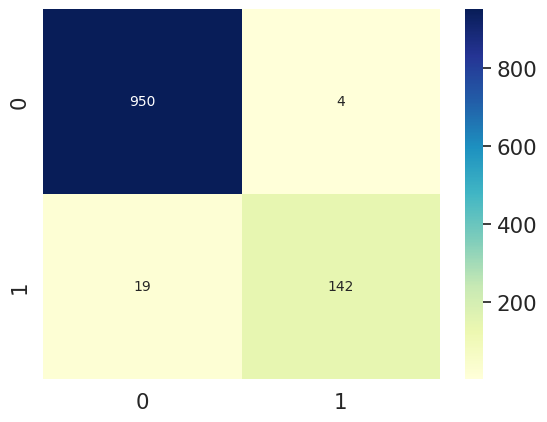

In [ ]:
#print the classification report to highlight the accuracy with f1-score, precision and recall
print(metrics.classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred)

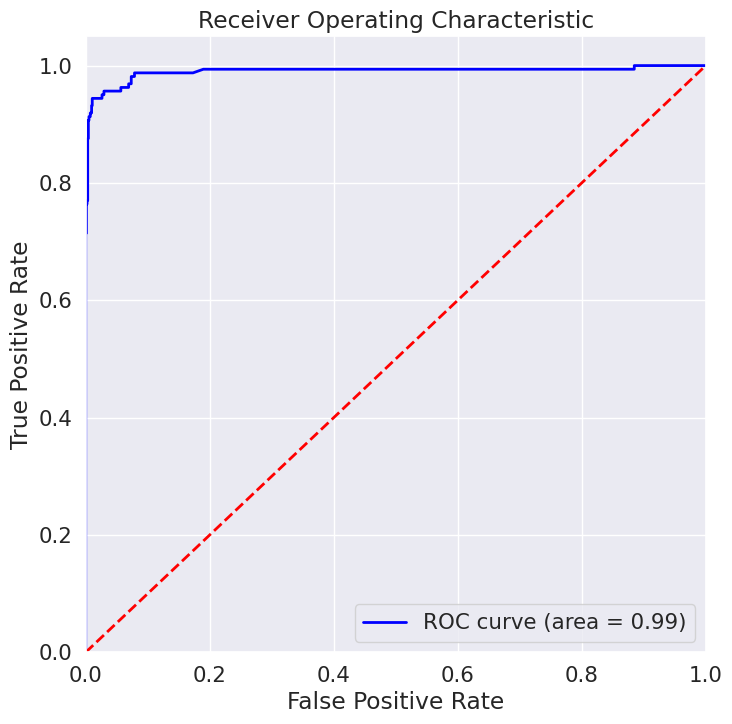

In [ ]:
# Function to plot ROC curve
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


# Assuming y_test is a list of strings representing the true labels
y_test_binary = [1 if label == 'spam' else 0 for label in y_test]

# Compute ROC curve and ROC area for the test set
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve for the test set
plot_roc_curve(fpr, tpr, roc_auc)

2. Word2Vec

In [12]:
def document_vector_avg(w2v_model, doc):
    vectors = [w2v_model.wv[word] for word in doc if word in w2v_model.wv.index_to_key]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)

X_train_avg = np.array([document_vector_avg(w2v_model, doc) for doc in X_train])
X_val_avg = np.array([document_vector_avg(w2v_model, doc) for doc in X_val])
X_test_avg = np.array([document_vector_avg(w2v_model, doc) for doc in X_test])

In [13]:
start_time = time.time()
model_Word2 = GridSearchCV(SVC(kernel='rbf', probability=True), parameters, cv=5, n_jobs=-1).fit(X_train_avg, y_train)

end_time = time.time()


training_time = end_time - start_time

print(f"GridSearchCV completed in {training_time:.2f} seconds")

GridSearchCV completed in 197.23 seconds


In [ ]:
print("Train score:", model_Word2.score(X_train_avg, y_train))
print("Validation score:", model_Word2.score(X_val_avg, y_val))

Train score: 0.9727870813397129
Validation score: 0.9587443946188341


In [ ]:
# Predicting the test set results
y_pred = model_Word2.predict(X_test_avg)
y_pred_prob = model_Word2.predict_proba(X_test_avg)[:, 1]

              precision    recall  f1-score   support

         ham       0.96      0.97      0.97       954
        spam       0.82      0.77      0.79       161

    accuracy                           0.94      1115
   macro avg       0.89      0.87      0.88      1115
weighted avg       0.94      0.94      0.94      1115



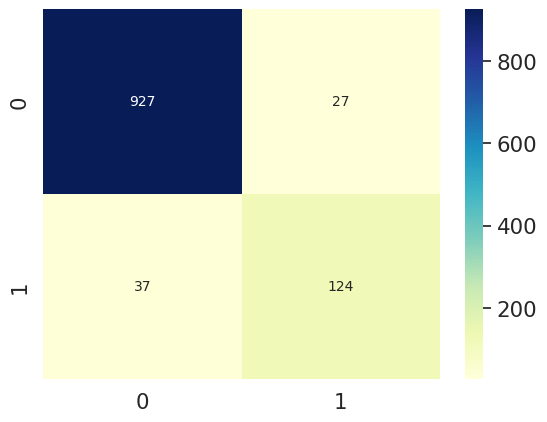

In [ ]:
#print the classification report to highlight the accuracy with f1-score, precision and recall
print(metrics.classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred)

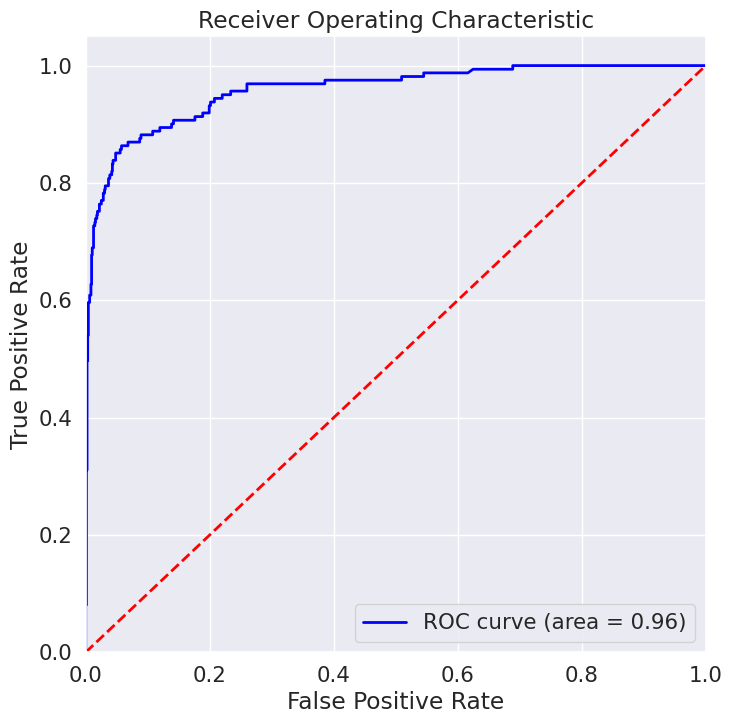

In [ ]:
# Function to plot ROC curve
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


# Assuming y_test is a list of strings representing the true labels
y_test_binary = [1 if label == 'spam' else 0 for label in y_test]

# Compute ROC curve and ROC area for the test set
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve for the test set
plot_roc_curve(fpr, tpr, roc_auc)

### **Deep Learning model**

**LSTM**
1. TF-IDF

In [45]:
pip install tensorflow

In [46]:
y_train_m = y_train.map({'ham': 0, 'spam': 1}).astype(int)
y_val_m = y_val.map({'ham': 0, 'spam': 1}).astype(int)
y_test_m = y_test.map({'ham': 0, 'spam': 1}).astype(int)


In [47]:
X_train_tfidf_dense = X_train_tfidf.toarray()
X_val_tfidf_dense = X_val_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()

In [48]:
X_train_tfidf_lstm = np.expand_dims(X_train_tfidf_dense, axis=1)
X_val_tfidf_lstm = np.expand_dims(X_val_tfidf_dense, axis=1)
X_test_tfidf_lstm = np.expand_dims(X_test_tfidf_dense, axis=1)

In [49]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
import tensorflow as tf

input_shape_tfidf = (1, 2676)

# Define input
input_tfidf = Input(shape=input_shape_tfidf)

# Process TF-IDF input using LSTM layer
lstm_tfidf = Bidirectional(LSTM(64, return_sequences=False))(input_tfidf)

# Dropout layer
dropout_tfidf = Dropout(0.2)(lstm_tfidf)

# Fully connected layer
fc_tfidf = Dense(64, activation='relu')(dropout_tfidf)

# Dropout layer
dropout_tfidf_2 = Dropout(0.2)(fc_tfidf)

# Output layer
output_tfidf = Dense(1, activation='sigmoid')(dropout_tfidf_2)

# Create and compile TF-IDF model
model_tfidf = Model(inputs=input_tfidf, outputs=output_tfidf)
model_tfidf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model_tfidf.summary()

start_time = time.time()  # Record training start time

# Train TF-IDF model
model_tfidf.fit(x=X_train_tfidf_lstm, y=y_train_m, epochs=10, batch_size=64, validation_data=(X_val_tfidf_lstm, y_val_m))

end_time = time.time()  # Record training end time
training_time = end_time - start_time  # Calculate total training time

print(f"Training completed in {training_time:.2f} seconds")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 2676)]         0         
                                                                 
 bidirectional (Bidirection  (None, 128)               1403392   
 al)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                             

In [ ]:
# Use the model to make predictions on the test data
y_pred_proba = model_tfidf.predict(X_test_tfidf_lstm)
y_pred = (y_pred_proba > 0.5).astype(int)  # Convert probabilities to class labels, using 0.5 as the threshold


35/35 [==============================] - 2s 10ms/step


              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       954
        spam       0.96      0.90      0.93       161

    accuracy                           0.98      1115
   macro avg       0.97      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



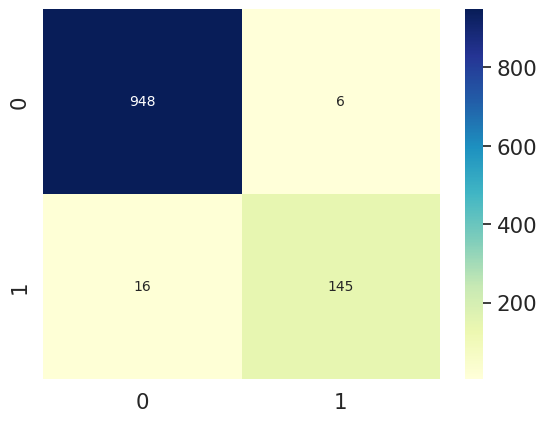

In [ ]:
report = classification_report(y_test_m, y_pred, target_names=['ham', 'spam'])
print(report)
plot_confusion_matrix(y_test_m, y_pred)

2. Word2Vec

In [79]:
input_shape_word2vec = (100, 200)

# Define input
input_word2vec = Input(shape=input_shape_word2vec)

# Process word2vec input using LSTM layer
lstm_word2vec = Bidirectional(LSTM(64, return_sequences=False))(input_word2vec)

# Dropout layer
dropout_word2vec = Dropout(0.2)(lstm_word2vec)

# Fully connected layer
fc_word2vec = Dense(64, activation='relu')(dropout_word2vec)

# Dropout layer
dropout_word2vec_2 = Dropout(0.2)(fc_word2vec)

# Output layer
output_word2vec = Dense(1, activation='sigmoid')(dropout_word2vec_2)

# Create and compile word2vec model
model_word2vec_without_weights = Model(inputs=input_word2vec, outputs=output_word2vec)

model_word2vec_without_weights.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model_word2vec_without_weights.summary()

start_time = time.time()  # Record training start time

# Train word2vec model
model_word2vec_without_weights.fit(x=X_train_sequences, y=y_train_m, epochs=10, batch_size=64, validation_data=(X_val_sequences, y_val_m))

end_time = time.time()  # Record training end time
training_time = end_time - start_time  # Calculate total training time

print(f"Training completed in {training_time:.2f} seconds")

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100, 200)]        0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 128)               135680    
 onal)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                           

In [80]:
y_pred_proba = model_word2vec_without_weights.predict(x=X_test_sequences)
y_pred_lstm_w2v = (y_pred_proba > 0.5).astype(int)

35/35 [==============================] - 7s 106ms/step


              precision    recall  f1-score   support

         ham       0.91      0.94      0.93       954
        spam       0.56      0.47      0.51       161

    accuracy                           0.87      1115
   macro avg       0.74      0.70      0.72      1115
weighted avg       0.86      0.87      0.87      1115



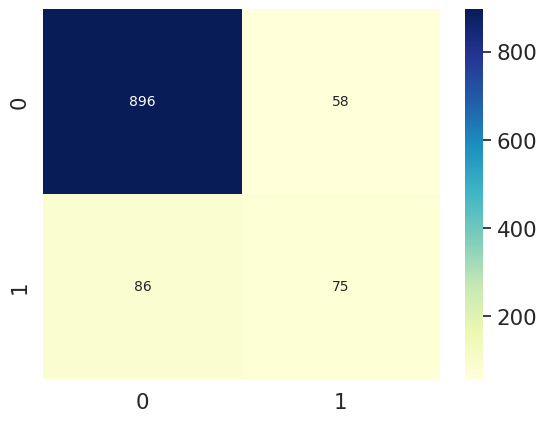

In [81]:
report = classification_report(y_test_m, y_pred_lstm_w2v, target_names=['ham', 'spam'])
print(report)
plot_confusion_matrix(y_test_m, y_pred_lstm_w2v)

In [75]:
# Assuming class labels are 0 for HAM and 1 for SPAM
class_weights = {
    0: 1 / 0.866,  # For HAM
    1: 1 / 0.134   # For SPAM
}

# Adjust to the inverse of the sample ratio
class_weights[0] *= (1 / sum(class_weights.values()))
class_weights[1] *= (1 / sum(class_weights.values()))

print(class_weights)

{0: 0.134, 1: 0.9823607307192059}


In [76]:
input_shape_word2vec = (100, 200)

# Define input
input_word2vec = Input(shape=input_shape_word2vec)

# Process word2vec input using LSTM layer
lstm_word2vec = Bidirectional(LSTM(64, return_sequences=False))(input_word2vec)

# Dropout layer
dropout_word2vec = Dropout(0.2)(lstm_word2vec)

# Fully connected layer
fc_word2vec = Dense(64, activation='relu')(dropout_word2vec)

# Dropout layer
dropout_word2vec_2 = Dropout(0.2)(fc_word2vec)

# Output layer
output_word2vec = Dense(1, activation='sigmoid')(dropout_word2vec_2)

# Create and compile word2vec model
model_word2vec = Model(inputs=input_word2vec, outputs=output_word2vec)

model_word2vec.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model_word2vec.summary()

start_time = time.time()  # Record training start time

# Train word2vec model
model_word2vec.fit(x=X_train_sequences, y=y_train_m, epochs=10, batch_size=64, validation_data=(X_val_sequences, y_val_m), class_weight=class_weights)

end_time = time.time()  # Record training end time
training_time = end_time - start_time  # Calculate total training time

print(f"Training completed in {training_time:.2f} seconds")

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100, 200)]        0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 128)               135680    
 onal)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                           

In [77]:
y_pred_proba = model_word2vec.predict(x=X_test_sequences)
y_pred_lstm_w2v = (y_pred_proba > 0.5).astype(int)

35/35 [==============================] - 4s 77ms/step


              precision    recall  f1-score   support

         ham       0.97      0.74      0.84       954
        spam       0.36      0.87      0.51       161

    accuracy                           0.76      1115
   macro avg       0.67      0.81      0.68      1115
weighted avg       0.88      0.76      0.79      1115



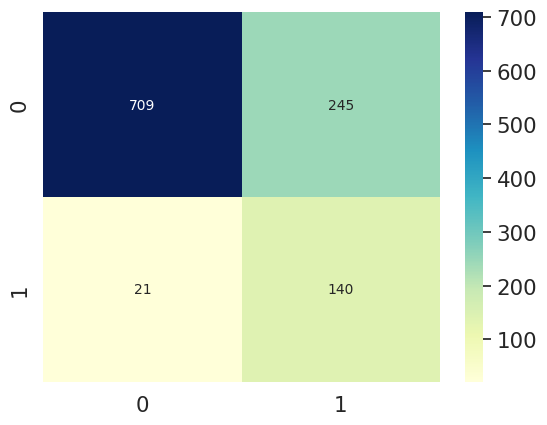

In [78]:
report = classification_report(y_test_m, y_pred_lstm_w2v, target_names=['ham', 'spam'])
print(report)
plot_confusion_matrix(y_test_m, y_pred_lstm_w2v)

### **Generate SPAM-like emails**

In [14]:
# Filter out all 'spam' data
spam_data = data[data['label'] == 'spam']['processed']

In [15]:
spam_data

2       [free, entry, 2, wkly, comp, win, fa, cup, fin...
5       [freemsg, hey, darle, 3, week, word, d, like, ...
8       [winner, value, network, customer, select, rec...
9       [mobile, 11, month, u, r, entitle, update, lat...
11      [chance, win, cash, 100, 20000, pound, txt, cs...
                              ...                        
5539    [want, explicit, sex, 30, sec, ring, 020731624...
5542    [ask, 3mobile, 0870, chatline, inclu, free, mi...
5549    [contract, mobile, 11, mnth, late, motorola, n...
5568    [reminder, o2, 250, pound, free, credit, detai...
5569    [2nd, time, try, 2, contact, u, u, win, 750, p...
Name: processed, Length: 747, dtype: object

In [16]:
texts = [' '.join(text) for text in spam_data.tolist()]

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [19]:
max_seq_length = max(len(seq) for seq in sequences)
sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

In [20]:
X = sequences
y = np.zeros((len(sequences), max_seq_length, len(tokenizer.word_index) + 1))
for i, sequence in enumerate(sequences):
    for t, word_index in enumerate(sequence):
        if t+1 < len(sequence):
            y[i, t, sequence[t+1]] = 1

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Concatenate
import tensorflow as tf

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=max_seq_length))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(tokenizer.word_index) + 1, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 27, 64)            169408    
                                                                 
 lstm_2 (LSTM)               (None, 27, 128)           98816     
                                                                 
 dropout_2 (Dropout)         (None, 27, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 27, 64)            49408     
                                                                 
 dropout_3 (Dropout)         (None, 27, 64)            0         
                                                                 
 dense_2 (Dense)             (None, 27, 32)            2080      
                                                                 
 dense_3 (Dense)             (None, 27, 2647)         

In [24]:
model.fit(X, y, epochs=10, batch_size=32)

Epoch 1/10
24/24 [==============================] - 8s 114ms/step - loss: 7.2297 - accuracy: 0.4145
Epoch 2/10
24/24 [==============================] - 6s 265ms/step - loss: 5.1092 - accuracy: 0.4542
Epoch 3/10
24/24 [==============================] - 7s 274ms/step - loss: 4.4392 - accuracy: 0.4542
Epoch 4/10
24/24 [==============================] - 3s 111ms/step - loss: 4.3764 - accuracy: 0.4534
Epoch 5/10
24/24 [==============================] - 3s 112ms/step - loss: 4.3004 - accuracy: 0.4537
Epoch 6/10
24/24 [==============================] - 3s 111ms/step - loss: 4.1545 - accuracy: 0.4542
Epoch 7/10
24/24 [==============================] - 4s 147ms/step - loss: 4.0097 - accuracy: 0.4542
Epoch 8/10
24/24 [==============================] - 4s 163ms/step - loss: 3.9232 - accuracy: 0.4543
Epoch 9/10
24/24 [==============================] - 3s 114ms/step - loss: 3.8712 - accuracy: 0.4543
Epoch 10/10
24/24 [==============================] - 3s 114ms/step - loss: 3.8314 - accuracy: 0.4564

In [25]:
def generate_text(seed_text, next_words=50):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_seq_length, padding='post')
        predicted_probs = model.predict(token_list, verbose=0)
        # Select the index of the most likely word at the last time step
        predicted_index = np.argmax(predicted_probs[0, -1])
        output_word = ""
        # Find the corresponding word by index
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

# Generate 100 samples
generated_texts = []
for _ in range(100):
    seed_text = np.random.choice(texts)
    print(generate_text(seed_text))
    generated_text = generate_text(seed_text)
    generated_texts.append(generated_text)


win nokia 7250i win free auction send nokia 86021 hgsuite3422land roww1jhl 16                                                  
weekly coolmob tone ready download week new tone include 1 crazy frogaxel f 2 akonlonely 3 black eyeddont p info n                                                  
phony 350 award today voda number end xxxx select receive 350 award match 08712300220 quote claim code 3100 standard rate app                                                  
win 1000 cash 2000 prize claim call09050000327                                                  
romantic paris 2 night 2 flight 79 book 4 year 08704439680tscs apply                                                  
today vodafone number end 4882 select receive 350 award number match 09064019014 receive 350 award                                                  
sunshine hol claim ur med holiday send stamp self address envelope drink uk po box 113 bray wicklow eire quiz start saturday unsub stop                               

### **Sample Test**

In [34]:
preprocessed_texts = [preprocess_text(text, nlp) for text in generated_texts]

In [35]:
text_features = vectorizer.transform(preprocessed_texts)

In [38]:
text_features.shape

(100, 2676)

In [42]:
# Assuming svm_predictions is the output from model.predict()
svm_predictions = model_svm.predict(text_features)

# Convert numpy array to pandas Series
svm_predictions_series = pd.Series(svm_predictions)

# Map 'ham' to 0 and 'spam' to 1
svm_predictions_mapped = svm_predictions_series.map({'ham': 0, 'spam': 1}).astype(int)


In [67]:
# Convert the generated text into a sequence
sequences_generated = tokenizer.texts_to_sequences(preprocessed_texts)
X_generated_lstm = pad_sequences(sequences_generated, maxlen=2676, padding='post')
X_generated_lstm = np.expand_dims(X_generated_lstm, axis=1)

In [68]:
# Prediction
lstm_predictions = model_tfidf.predict(X_generated_lstm)
lstm_predictions = (lstm_predictions > 0.5).astype(int) # Convert probabilities to class labels

4/4 [==============================] - 0s 14ms/step


In [69]:
from sklearn.metrics import classification_report

# True labels, assuming all generated samples are spam emails
true_labels = [1] * 100  # 1 represents spam emails

# Generate reports
print("SVM Model Performance on Generated Texts:")
print(classification_report(true_labels, svm_predictions_mapped))

print("LSTM Model Performance on Generated Texts:")
print(classification_report(true_labels, lstm_predictions))


SVM Model Performance on Generated Texts:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.95      0.97       100

    accuracy                           0.95       100
   macro avg       0.50      0.47      0.49       100
weighted avg       1.00      0.95      0.97       100

LSTM Model Performance on Generated Texts:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       100

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
